### Model 2

In [1]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [2]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes, finalAct="softmax"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = 3
        
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes))
        model.add(Activation(finalAct))
        # return the constructed network architecture
        return model

In [5]:
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os

In [6]:
EPOCHS = 175
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

In [7]:
imagePaths = []
for dirname, _, filenames in os.walk(r'/kaggle/input/dataset/'):
    for filename in filenames:
        imagePaths.append(os.path.join(dirname, filename))
        
imagePaths = sorted(imagePaths)
random.seed(42)
random.shuffle(imagePaths)

In [8]:
data = []
labels = []

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)
    
    l = label = imagePath.split(os.path.sep)[-2]
    labels.append((l,))
    
labels[0:5]

[('Knock',),
 ('Knock',),
 ('Zipper_(clothing)',),
 ('Accordion',),
 ('Bicycle_bell',)]

In [9]:
print(len(data))
print(len(labels))

12002
12002


In [10]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels) 

mlb = MultiLabelBinarizer() 
labels = mlb.fit_transform(labels) 
mlb.classes_

array(['Accelerating_and_revving_and_vroom', 'Accordion',
       'Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Bass_guitar',
       'Bathtub_(filling_or_washing)', 'Bicycle_bell',
       'Burping_and_eructation', 'Bus', 'Buzz', 'Car_passing_by',
       'Cheering', 'Chewing_and_mastication',
       'Child_speech_and_kid_speaking', 'Chink_and_clink',
       'Chirp_and_tweet', 'Church_bell', 'Clapping', 'Computer_keyboard',
       'Crackle', 'Cricket', 'Crowd', 'Cupboard_open_or_close',
       'Cutlery_and_silverware', 'Dishes_and_pots_and_pans',
       'Drawer_open_or_close', 'Drip', 'Electric_guitar', 'Fart',
       'Female_singing', 'Female_speech_and_woman_speaking',
       'Fill_(with_liquid)', 'Finger_snapping', 'Frying_(food)', 'Gasp',
       'Glockenspiel', 'Gong', 'Gurgling', 'Harmonica', 'Hi-hat', 'Hiss',
       'Keys_jangling', 'Knock', 'Male_singing',
       'Male_speech_and_man_speaking', 'Marimba_and_xylophone',
       'Mechanical_fan', 'Meow', 'Microwave_oven', 'Moto

In [11]:
(train_X, valid_X, train_y, valid_y) = train_test_split(data, labels, test_size=0.2, random_state=2018)

In [12]:
model = SmallerVGGNet.build(
    width = IMAGE_DIMS[1],
    height = IMAGE_DIMS[0],
    depth = IMAGE_DIMS[2],
    classes = len(mlb.classes_),
    finalAct = "sigmoid"
)

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)

In [17]:
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("Training network...")

H = model.fit(
    train_X, train_y,
    epochs = EPOCHS,
    batch_size = BS,
    validation_data = (valid_X, valid_y),
    verbose=1
)

Training network...
Train on 9601 samples, validate on 2401 samples
Epoch 1/175
9601/9601 [==============================] - 14s 2ms/step - loss: 0.2312 - accuracy: 0.9067 - val_loss: 0.0811 - val_accuracy: 0.9869
Epoch 2/175
9601/9601 [==============================] - 8s 882us/step - loss: 0.0584 - accuracy: 0.9869 - val_loss: 0.0587 - val_accuracy: 0.9874
Epoch 3/175
9601/9601 [==============================] - 8s 864us/step - loss: 0.0516 - accuracy: 0.9871 - val_loss: 0.0493 - val_accuracy: 0.9875
Epoch 4/175
9601/9601 [==============================] - 8s 871us/step - loss: 0.0484 - accuracy: 0.9875 - val_loss: 0.0492 - val_accuracy: 0.9869
Epoch 5/175
9601/9601 [==============================] - 8s 875us/step - loss: 0.0448 - accuracy: 0.9878 - val_loss: 0.0574 - val_accuracy: 0.9861
Epoch 6/175
9601/9601 [==============================] - 8s 882us/step - loss: 0.0417 - accuracy: 0.9883 - val_loss: 0.0431 - val_accuracy: 0.9882
Epoch 7/175
9601/9601 [============================

Epoch 56/175
9601/9601 [==============================] - 9s 915us/step - loss: 0.0137 - accuracy: 0.9943 - val_loss: 0.0602 - val_accuracy: 0.9861
Epoch 57/175
9601/9601 [==============================] - 9s 895us/step - loss: 0.0134 - accuracy: 0.9944 - val_loss: 0.0593 - val_accuracy: 0.9860
Epoch 58/175
9601/9601 [==============================] - 9s 891us/step - loss: 0.0137 - accuracy: 0.9944 - val_loss: 0.0586 - val_accuracy: 0.9863
Epoch 59/175
9601/9601 [==============================] - 9s 918us/step - loss: 0.0135 - accuracy: 0.9944 - val_loss: 0.0609 - val_accuracy: 0.9862
Epoch 60/175
9601/9601 [==============================] - 9s 896us/step - loss: 0.0132 - accuracy: 0.9945 - val_loss: 0.0602 - val_accuracy: 0.9860
Epoch 61/175
9601/9601 [==============================] - 9s 898us/step - loss: 0.0127 - accuracy: 0.9947 - val_loss: 0.0604 - val_accuracy: 0.9860
Epoch 62/175
9601/9601 [==============================] - 9s 945us/step - loss: 0.0127 - accuracy: 0.9946 - val_

9601/9601 [==============================] - 8s 867us/step - loss: 0.0093 - accuracy: 0.9954 - val_loss: 0.0634 - val_accuracy: 0.9861
Epoch 167/175
9601/9601 [==============================] - 9s 900us/step - loss: 0.0095 - accuracy: 0.9952 - val_loss: 0.0643 - val_accuracy: 0.9859
Epoch 168/175
9601/9601 [==============================] - 9s 911us/step - loss: 0.0094 - accuracy: 0.9952 - val_loss: 0.0625 - val_accuracy: 0.9861
Epoch 169/175
9601/9601 [==============================] - 8s 872us/step - loss: 0.0094 - accuracy: 0.9952 - val_loss: 0.0647 - val_accuracy: 0.9859
Epoch 170/175
9601/9601 [==============================] - 8s 871us/step - loss: 0.0092 - accuracy: 0.9954 - val_loss: 0.0647 - val_accuracy: 0.9859
Epoch 171/175
9601/9601 [==============================] - 8s 875us/step - loss: 0.0093 - accuracy: 0.9953 - val_loss: 0.0645 - val_accuracy: 0.9860
Epoch 172/175
9601/9601 [==============================] - 8s 870us/step - loss: 0.0094 - accuracy: 0.9952 - val_loss: 0

(0.0, 1.0)

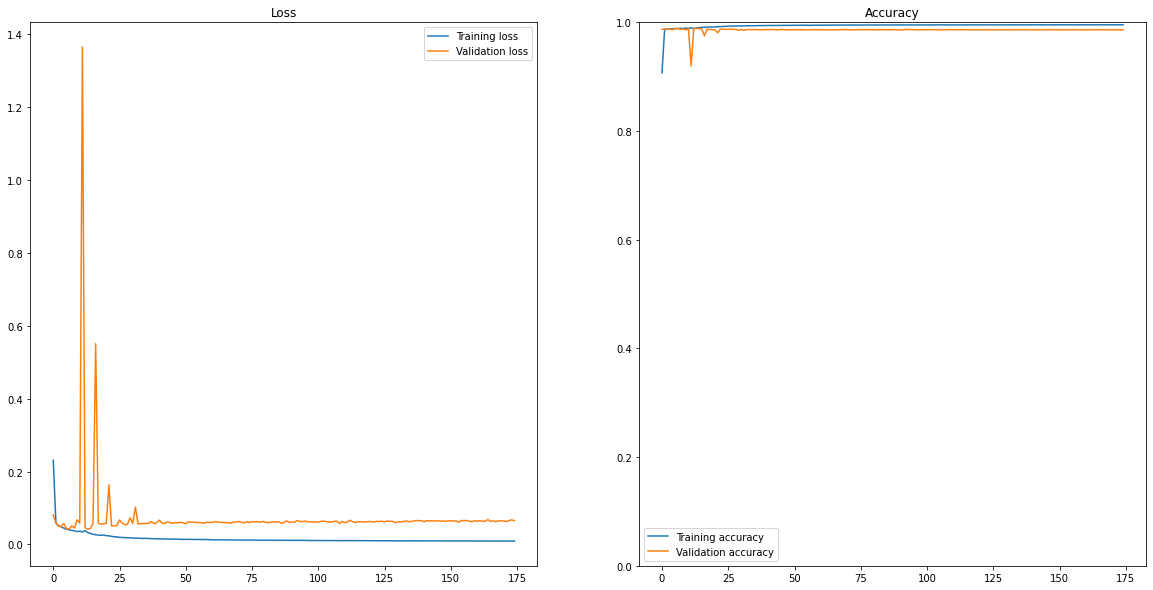

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(H.history['loss'], label='Training loss')
ax1.plot(H.history['val_loss'], label='Validation loss')
ax1.legend()
ax1.set_title('Loss')

ax2.plot(H.history["accuracy"], label='Training accuracy')
ax2.plot(H.history["val_accuracy"], label='Validation accuracy')
ax2.legend()
ax2.set_title('Accuracy')
ax2.set_ylim(0, 1)

In [20]:
model.save('svggnet.h5')

f = open("mlb.pickle", "wb")
f.write(pickle.dumps(mlb))
f.close()